In [1]:
# Attempting to recover training data using model's parameters and a DCGAN that was trained on similar data
# Author: Suraj Neupane
# Written from scratch as a part of a Research Project 2025, Concordia University of Edmonton.
import numpy as np

import torch
from torch import nn
from torch.nn import functional

from torch.utils import data
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.__version__

'2.5.1+cu118'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

In [5]:
# DCGAN Implementation Class
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super().__init__()
        self.disc = nn.Sequential(
            # Input shape: img_channels x 64 x 64
            nn.Conv2d(
              in_channels=img_channels, out_channels=features_d, kernel_size=4, stride=2, padding=1
            ), # Output shape: features_d x 32 x 32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1), # Output shape: features_d*2 x 16 x 16
            self._block(features_d*2, features_d*4, 4, 2, 1), # Output shape: features_d*4 x 8 x 8
            self._block(features_d*4, features_d*8, 4, 2, 1), # Output shape: features_d*8 x 4 x 4
           
            nn.Conv2d(in_channels=features_d*8, out_channels=1, kernel_size=4, stride=2, padding=0), # Output shape: 1 x 1
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, X):
        return self.disc(X)


In [6]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, features_g):
        super().__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g*16, 4, 1, 0), # z_dim: (batch_size, 100, 1, 1) -> (batch_size, 1024, 4, 4)
            self._block(features_g*16, features_g*8, 4, 2, 1), # z_dim: (batch_size, 1024, 4, 4) -> (batch_size, 512, 8, 8)
            self._block(features_g*8, features_g*4, 4, 2, 1), # z_dim: (batch_size, 512, 8, 8) -> (batch_size, 256, 16, 16)
            self._block(features_g*4, features_g*2, 4, 2, 1), # z_dim: (batch_size, 128, 16, 16) -> (batch_size, 64, 32, 32)
            nn.ConvTranspose2d(
                in_channels=features_g*2, out_channels=img_channels, kernel_size=4, stride=2, padding=1 # z_dim: (batch_size, 64, 32, 32) -> (batch_size, 1, 64, 64)
            ),
            nn.Tanh(),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, X):
        return self.gen(X)

In [7]:
# Hyperparams
z_dim = 100
img_channels = 1
features_disc = 64
features_gen = 64

In [8]:
# Create the model instances
gen = Generator(z_dim, img_channels, features_gen).to(device)
disc = Discriminator(img_channels, features_disc).to(device)

In [9]:
# Load the trained GAN
gen.load_state_dict(torch.load('saved models/Generator.pth', weights_only=True))
disc.load_state_dict(torch.load('saved models/Discriminator.pth', weights_only=True))

<All keys matched successfully>

In [10]:
# Generate a random fake image
noise = torch.randn(1, z_dim, 1, 1).to(device)
fake_img = gen(noise)

In [11]:
fake_img.shape

torch.Size([1, 1, 64, 64])

torch.Size([64, 64])


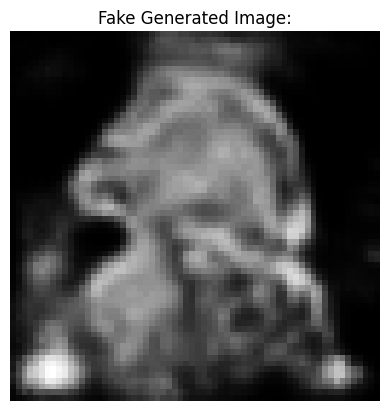

In [12]:
fake_img = fake_img.squeeze()
print(fake_img.shape)
plt.axis(False)
plt.title('Fake Generated Image:')
plt.imshow(fake_img.cpu().detach(), cmap='gray')

In [74]:
# Target Model
class TFCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            Reshape(),
        )

        self.h_size = 64 * 4 * 4

        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(True),
            nn.Linear(128, n_classes)
        )

    def forward(self, xs):
        code = self.encoder(xs)
        logits = self.classifier(code)
        return code, logits


In [75]:
class Reshape(nn.Module):
    def __init__(self,):
        super().__init__()

    def forward(self, xs):
        return xs.reshape((xs.shape[0], -1))

In [15]:
class ClassifyNet(nn.Module):
    def __init__(self, net, init_way, n_classes, input_size=None):
        super().__init__()
        self.net = net
        self.init_way = init_way
        self.n_classes = n_classes

        model = TFCNN(n_classes)

        self.h_size = model.h_size

        # Convo and pool layers
        self.encoder = model.encoder

        # Classifier layer
        self.classifier = nn.Linear(
            self.h_size, self.n_classes, bias=False
        )

        if self.init_way == "orth":
            ws = get_orth_weights(self.h_size, self.n_classes)
            self.classifier.load_state_dict({"weight": ws})

    def forward(self, xs):
        hs = self.encoder(xs)
        logits = self.classifier(hs)
        return hs, logits

In [76]:
def load_target_model(base_net, n_classes, path):
    # Create the base model
    model = ClassifyNet(net=base_net, init_way='none', n_classes=n_classes)
    # Load the model
    model.load_state_dict(torch.load(path, weights_only=True))

    return model

In [77]:
# Target Model Loading
BASE_NET = 'TFCNN'
DATASET = 'tumor4'
N_CLASSES = 4

target_model = load_target_model(base_net=BASE_NET, n_classes=N_CLASSES, path='saved models/fedavg_global_model.pth').to(device)
print('Model loaded successfully!')
target_model.eval()

num_params = sum(p.numel() for p in target_model.parameters())
print('Number of parameters in the loaded model:', num_params)


Model loaded successfully!
Number of parameters in the loaded model: 60416


In [18]:
# BEGIN BATCH MODEL INVERSION
img_count = 20
latent_vectors = torch.randn(img_count, z_dim, 1, 1, requires_grad=True) # Start with 20 random noises

In [19]:
def recover_images(count, target_image_class, latent_vectors):
    optimized_latent_vectors = []
    
    for x in range(0, count):
        z = latent_vectors[x].unsqueeze(dim=0).clone().detach().requires_grad_(True)
        
        learning_rate = 0.01
        target_class = 1 # The second class
        
        # Create the optimizer
        optimizer = torch.optim.Adam([z], lr=learning_rate)
        
        # Loss function (e.g., Cross-Entropy with classifier outputs)
        loss_fn = nn.CrossEntropyLoss()
        target_class = torch.tensor([target_image_class])  # Set the target class
    
        # Optimization loop to find the best z
        rounds = 500
        for i in range(rounds):
            optimizer.zero_grad()
            
            generated_image = gen(z.to(device))  # Generate an image from the latent vector
            generated_image = generated_image.repeat(1, 3, 1, 1)
            generated_image = functional.interpolate(generated_image, size=(32, 32), mode='nearest')
            #print(generated_image.shape)
            hs, prediction_logits = target_model(generated_image)  # Classifier output
            #print(prediction_logits)
            #print(type(prediction_logits))
            loss = loss_fn(prediction_logits, target_class.to(device))  # Minimize difference with true class
            loss.backward()
            optimizer.step()
            
            if i % 50 == 0:
                print(f"Generating Image Number: {x+1} for target class {target_class}. Step {i}, Loss: {loss.item()}")
    
        optimized_latent_vectors.append(z)
        
    return optimized_latent_vectors

In [20]:
class0_optimized_latent_vectors = recover_images(img_count, 0, latent_vectors)

Generating Image Number: 1 for target class tensor([0]). Step 0, Loss: 3.1393401622772217
Generating Image Number: 1 for target class tensor([0]). Step 50, Loss: 1.00143563747406
Generating Image Number: 1 for target class tensor([0]). Step 100, Loss: 0.6972113251686096
Generating Image Number: 1 for target class tensor([0]). Step 150, Loss: 0.5716810822486877
Generating Image Number: 1 for target class tensor([0]). Step 200, Loss: 0.34226658940315247
Generating Image Number: 1 for target class tensor([0]). Step 250, Loss: 0.19873899221420288
Generating Image Number: 1 for target class tensor([0]). Step 300, Loss: 0.14651131629943848
Generating Image Number: 1 for target class tensor([0]). Step 350, Loss: 0.1182667464017868
Generating Image Number: 1 for target class tensor([0]). Step 400, Loss: 0.10020335018634796
Generating Image Number: 1 for target class tensor([0]). Step 450, Loss: 0.0840202271938324
Generating Image Number: 2 for target class tensor([0]). Step 0, Loss: 0.30801451

In [21]:
torch.manual_seed(100)
latent_vectors = torch.randn(img_count, z_dim, 1, 1, requires_grad=True) # Start with 20 random noises
class1_optimized_latent_vectors = recover_images(img_count, 1, latent_vectors)

Generating Image Number: 1 for target class tensor([1]). Step 0, Loss: 1.5556334257125854
Generating Image Number: 1 for target class tensor([1]). Step 50, Loss: 0.0838390365242958
Generating Image Number: 1 for target class tensor([1]). Step 100, Loss: 0.03454224765300751
Generating Image Number: 1 for target class tensor([1]). Step 150, Loss: 0.017173277214169502
Generating Image Number: 1 for target class tensor([1]). Step 200, Loss: 0.008125345222651958
Generating Image Number: 1 for target class tensor([1]). Step 250, Loss: 0.005923929158598185
Generating Image Number: 1 for target class tensor([1]). Step 300, Loss: 0.004595077130943537
Generating Image Number: 1 for target class tensor([1]). Step 350, Loss: 0.003822284284979105
Generating Image Number: 1 for target class tensor([1]). Step 400, Loss: 0.003175813239067793
Generating Image Number: 1 for target class tensor([1]). Step 450, Loss: 0.002457219874486327
Generating Image Number: 2 for target class tensor([1]). Step 0, Los

In [22]:
torch.manual_seed(200)
latent_vectors = torch.randn(img_count, z_dim, 1, 1, requires_grad=True) # Start with 20 random noises
class2_optimized_latent_vectors = recover_images(img_count, 2, latent_vectors)

Generating Image Number: 1 for target class tensor([2]). Step 0, Loss: 1.8476500511169434
Generating Image Number: 1 for target class tensor([2]). Step 50, Loss: 0.19365473091602325
Generating Image Number: 1 for target class tensor([2]). Step 100, Loss: 0.1337304413318634
Generating Image Number: 1 for target class tensor([2]). Step 150, Loss: 0.10570994019508362
Generating Image Number: 1 for target class tensor([2]). Step 200, Loss: 0.08062577992677689
Generating Image Number: 1 for target class tensor([2]). Step 250, Loss: 0.06317541748285294
Generating Image Number: 1 for target class tensor([2]). Step 300, Loss: 0.05401337519288063
Generating Image Number: 1 for target class tensor([2]). Step 350, Loss: 0.04741406440734863
Generating Image Number: 1 for target class tensor([2]). Step 400, Loss: 0.04315919801592827
Generating Image Number: 1 for target class tensor([2]). Step 450, Loss: 0.03948152810335159
Generating Image Number: 2 for target class tensor([2]). Step 0, Loss: 2.36

In [23]:
torch.manual_seed(300)
latent_vectors = torch.randn(img_count, z_dim, 1, 1, requires_grad=True) # Start with 20 random noises
class3_optimized_latent_vectors = recover_images(img_count, 3, latent_vectors)

Generating Image Number: 1 for target class tensor([3]). Step 0, Loss: 1.3415765762329102
Generating Image Number: 1 for target class tensor([3]). Step 50, Loss: 0.016639500856399536
Generating Image Number: 1 for target class tensor([3]). Step 100, Loss: 0.004872709512710571
Generating Image Number: 1 for target class tensor([3]). Step 150, Loss: 0.0031998169142752886
Generating Image Number: 1 for target class tensor([3]). Step 200, Loss: 0.0023041623644530773
Generating Image Number: 1 for target class tensor([3]). Step 250, Loss: 0.0019326595356687903
Generating Image Number: 1 for target class tensor([3]). Step 300, Loss: 0.001702646492049098
Generating Image Number: 1 for target class tensor([3]). Step 350, Loss: 0.001553520211018622
Generating Image Number: 1 for target class tensor([3]). Step 400, Loss: 0.00142020417843014
Generating Image Number: 1 for target class tensor([3]). Step 450, Loss: 0.0012999664759263396
Generating Image Number: 2 for target class tensor([3]). Step 

In [24]:
z0_1 = class0_optimized_latent_vectors[0]
z0_2 = class0_optimized_latent_vectors[1]
z0_3 = class0_optimized_latent_vectors[2]

In [43]:
# Display the generated image
img = gen(z0_1.to(device)).squeeze(dim=0).squeeze(dim=0)
print(img.shape)

torch.Size([64, 64])


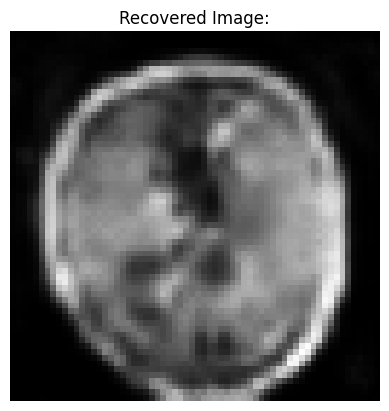

In [44]:
plt.axis(False)
plt.title('Recovered Image:')
plt.imshow(img.cpu().detach(), cmap='gray')

In [27]:
z1 = class1_optimized_latent_vectors[0]
z2 = class1_optimized_latent_vectors[1]
z3 = class1_optimized_latent_vectors[2]

In [41]:
# Display the generated image
img = gen(z1.to(device)).squeeze(dim=0).squeeze(dim=0)
print(img.shape)

torch.Size([64, 64])


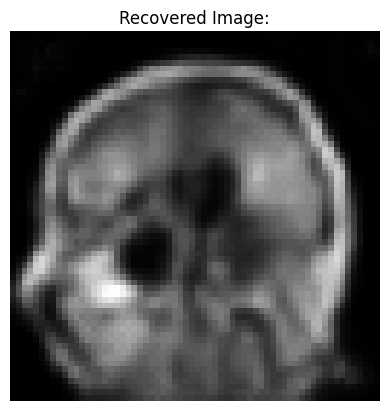

In [42]:
plt.axis(False)
plt.title('Recovered Image:')
plt.imshow(img.cpu().detach(), cmap='gray')

In [32]:
# Display the generated image
img = gen(latent_vectors[0].to(device)).squeeze(dim=0).squeeze(dim=0)
print(img.shape)

torch.Size([64, 64])


In [45]:
                                                            # Dataset Loading
# Load the .pkl files in as numpy arrays of pixels
def load_tumor_data(file_path):
    train_xs = []
    train_ys = []
    """ Load Digits Data from pickle data
    return:
    @xs: numpy.array, (n, c, w, h) 
    @ys: numpy.array, (n, ), 0-9
    """
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        train_xs.append(data["data"])
        train_ys.append(data["labels"])
    train_xs = np.concatenate(train_xs, axis=0)
    train_ys = np.concatenate(train_ys, axis=0)
    
    return train_xs, train_ys

In [46]:
# Custom Tumor Dataset
class TumorDataset(data.Dataset):
    def __init__(self, xs, ys, is_train=True):
        self.xs = xs
        self.ys = ys

        if is_train is True:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.5],
                    [0.5]
                )
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.4914, 0.4822, 0.4465),
                    (0.2023, 0.1994, 0.2010)
                )
            ])

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, index):
        img = self.xs[index]
        #print(img.shape)
        label = self.ys[index]

        img = img.transpose((1, 2, 0)).astype(np.uint8)
        img = self.transform(img)

        img = torch.FloatTensor(img)
        label = torch.LongTensor([label])[0]
        return img, label

In [47]:
def create_dataset(train_xs, train_ys):
    tumor_dataset = TumorDataset(train_xs, train_ys, is_train=True)

    return tumor_dataset

In [48]:
def create_dataloader(dataset):
    dataloader = DataLoader(dataset=dataset, batch_size=128, shuffle=True)

    return dataloader

In [49]:
# Load in the pickle dataset file
train_xs, train_ys = load_tumor_data('datasets/Tumor/tumor4train.pkl')
#train_xs = train_xs[:, 1, :, :]
#train_xs = np.expand_dims(train_xs, axis=1)
train_xs = train_xs.mean(axis=1, keepdims=True)
print(train_xs.shape)
print(type(train_xs))

(13927, 1, 32, 32)
<class 'numpy.ndarray'>


In [50]:
# Create the dataset
tumor_dataset = create_dataset(train_xs, train_ys)

In [51]:
def visualize_image(image_x):
    # We have to visualize by reverting the normalization (just for visualization).
    mean = torch.tensor([0.5])
    std = torch.tensor([0.5])

    image = image_x * std + mean  # Denormalize the image

    image = torch.clamp(image, 0, 1) # Clip values to [0, 1] to ensure valid range for display

    # Permute the image to (H, W, C) for matplotlib
    
    image = image.permute(1, 2, 0)

    plt.imshow(image, cmap='gray')

torch.Size([1, 64, 64])


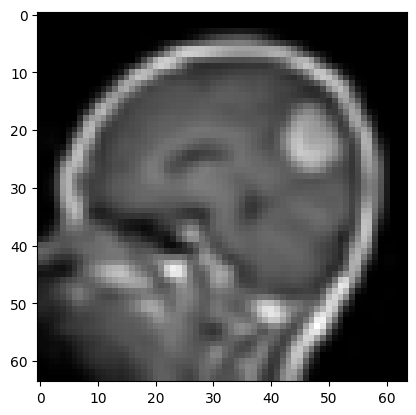

In [52]:
# Visualize the first tumor sample. 
image_x, image_y = tumor_dataset[7000]
print(image_x.shape)
visualize_image(image_x)

In [53]:
from scipy.spatial.distance import cosine

In [101]:
# Get the feature embeddings
tfcnn_model = target_model = load_target_model(base_net='TFCNN', n_classes=4, path='saved models/fedavg_global_model.pth').to(device)
model_embeddings = tfcnn_model.encoder.to(device)

In [102]:
# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

In [121]:
def get_feature(img):
    with torch.no_grad():
        features = model_embeddings(img).squeeze()
    return features.cpu().numpy()

In [122]:
# Send an original image through the model
image_x, image_y = tumor_dataset[10]
image_x.shape

torch.Size([1, 64, 64])

In [123]:
image_x = image_x.unsqueeze(dim=0)

In [124]:
image_x.shape

torch.Size([1, 1, 64, 64])

In [125]:
image_x = image_x.repeat(1, 3, 1, 1)
image_x = image_x.to(device)
image_x.shape

torch.Size([1, 3, 64, 64])

In [126]:
features = get_feature(image_x)
features.shape

(4096,)

In [132]:
class0_original_images = []
class1_original_images = []
class2_original_images = []
class3_original_images = []
target_num = 20 # 20 images for each class

In [133]:
for i in range(len(tumor_dataset)):
    img_x, img_y = tumor_dataset[i]

    if img_y == 0:
        if len(class0_original_images) < target_num:
            class0_original_images.append(img_x)
    elif img_y == 1:
        if len(class1_original_images) < target_num:
            class1_original_images.append(img_x)
    elif img_y == 2:
        if len(class2_original_images) < target_num:
            class2_original_images.append(img_x)
    elif img_y == 3:
        if len(class3_original_images) < target_num:
            class3_original_images.append(img_x)

In [188]:
len(class1_original_images)

20

In [198]:
# Testing the cosine similarity
class1_original_image = class1_original_images[8]
class1_original_image = class1_original_image.unsqueeze(dim=0).to(device)
class1_original_image = class1_original_image.repeat(1, 3, 1, 1)
class1_original_image.shape

torch.Size([1, 3, 64, 64])

In [199]:
fake1 = class1_optimized_latent_vectors[8]
fake1_image = gen(fake1.to(device))
fake1_image = fake1_image.repeat(1, 3, 1, 1)

In [200]:
fake0_image.shape

torch.Size([1, 3, 64, 64])

In [201]:
# Get the features of the images
features_original = get_feature(class1_original_image)
features_fake = get_feature(fake1_image)

In [202]:
# Compute cosine similarity
similarity = 1 - cosine(features_original, features_fake)

In [203]:
similarity

np.float32(0.281375)

In [238]:
def calculate_class0_sim():
    similarity = 0
    for i in range(0, 20):
        class0_original = class0_original_images[i].unsqueeze(dim=0).to(device)
        class0_original = class0_original.repeat(1, 3, 1, 1)

        class0_fake = class0_optimized_latent_vectors[i]
        class0_fake_img = gen(class0_fake.to(device))
        class0_fake_img = class0_fake_img.repeat(1, 3, 1, 1)

        features_original = get_feature(class0_original)
        features_fake = get_feature(class0_fake_img)

        cosine_similarity = 1 - cosine(features_original, features_fake)
        similarity += cosine_similarity

    similarity = similarity / 20
    return similarity

In [239]:
def calculate_class1_sim():
    similarity = 0
    for i in range(0, 20):
        class1_original = class1_original_images[i].unsqueeze(dim=0).to(device)
        class1_original = class1_original.repeat(1, 3, 1, 1)

        class1_fake = class1_optimized_latent_vectors[i]
        class1_fake_img = gen(class1_fake.to(device))
        class1_fake_img = class1_fake_img.repeat(1, 3, 1, 1)

        features_original = get_feature(class1_original)
        features_fake = get_feature(class1_fake_img)

        cosine_similarity = 1 - cosine(features_original, features_fake)
        similarity += cosine_similarity

    similarity = similarity / 20
    return similarity
        

In [240]:
def calculate_class2_sim():
    similarity = 0
    for i in range(0, 20):
        class2_original = class2_original_images[i].unsqueeze(dim=0).to(device)
        class2_original = class2_original.repeat(1, 3, 1, 1)

        class2_fake = class2_optimized_latent_vectors[i]
        class2_fake_img = gen(class2_fake.to(device))
        class2_fake_img = class2_fake_img.repeat(1, 3, 1, 1)

        features_original = get_feature(class2_original)
        features_fake = get_feature(class2_fake_img)

        cosine_similarity = 1 - cosine(features_original, features_fake)
        similarity += cosine_similarity

    similarity = similarity / 20
    return similarity

In [241]:
def calculate_class3_sim():
    similarity = 0
    for i in range(0, 20):
        class3_original = class3_original_images[i].unsqueeze(dim=0).to(device)
        class3_original = class3_original.repeat(1, 3, 1, 1)

        class3_fake = class3_optimized_latent_vectors[i]
        class3_fake_img = gen(class3_fake.to(device))
        class3_fake_img = class3_fake_img.repeat(1, 3, 1, 1)

        features_original = get_feature(class3_original)
        features_fake = get_feature(class3_fake_img)

        cosine_similarity = 1 - cosine(features_original, features_fake)
        similarity += cosine_similarity

    similarity = similarity / 20
    return similarity

In [250]:
avg_sim_0 = calculate_class0_sim()
avg_sim_0

np.float32(0.3763941)

In [251]:
avg_sim_1 = calculate_class1_sim()
avg_sim_1

np.float32(0.2604649)

In [252]:
avg_sim_2 = calculate_class2_sim()
avg_sim_2

np.float32(0.30400282)

In [253]:
avg_sim_3 = calculate_class3_sim()
avg_sim_3

np.float32(0.2939765)